# Techniki interpretowalnosci modeli (XAI): wyjasnianie decyzji modeli w medycynie

## 1. Import bibliotek

In [49]:
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

try:
    import shap
    shap_available = True
except Exception:
    shap_available = False

try:
    import lime
    from lime.lime_text import LimeTextExplainer
    lime_available = True
except Exception:
    lime_available = False

rng = 42
np.random.seed(rng)


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## 2. Import i przygotowanie danych

In [50]:
df = pd.read_csv('CancerProstateSurvival.csv')
target_col = 'patient.vital_status'
df[target_col] = df[target_col].astype(int)
label_map = {0: 'alive', 1: 'dead'}
df['label'] = df[target_col].map(label_map)
feature_cols = [c for c in df.columns if c != target_col]
num_cols = df[feature_cols].select_dtypes(include=['number']).columns.tolist()
cat_cols = [c for c in feature_cols if c not in num_cols]

binned = {}
for c in num_cols:
    binned[c] = pd.qcut(df[c], q=5, duplicates='drop')

def row_to_text(row):
    tokens = []
    for c in feature_cols:
        val = row[c]
        if pd.isna(val):
            continue
        if c in num_cols:
            bin_val = binned[c].iloc[row.name]
            tokens.append(f"{c}_bin_{str(bin_val).replace(' ', '')}")
        else:
            v = str(val).strip().lower().replace(' ', '_')
            tokens.append(f"{c}_{v}")
    return " ".join(tokens)

df['text'] = df.apply(row_to_text, axis=1)
df['text_clean'] = df['text'].astype(str).str.lower().str.replace(r'[^a-z0-9\s]', ' ', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
print('Liczba dokumentow:', df.shape[0])
print('Rozklad etykiet:')
print(df['label'].value_counts())


Liczba dokumentow: 499
Rozklad etykiet:
label
alive    491
dead       8
Name: count, dtype: int64


## 3. Wektoryzacja tekstu

In [51]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df['text_clean'])
y = df['label']
label_counts = y.value_counts()
use_stratify = label_counts.min() >= 2
strat = y if use_stratify else None
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng, stratify=strat)
print('X_train:', X_train.shape, 'X_test:', X_test.shape)
print('Stratyfikacja:', 'tak' if use_stratify else 'nie')


X_train: (399, 143) X_test: (100, 143)
Stratyfikacja: tak


## 4. Model klasyfikacyjny

Accuracy: 0.98
Precision (macro): 0.49
Recall (macro): 0.5
F1 (macro): 0.494949494949495


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


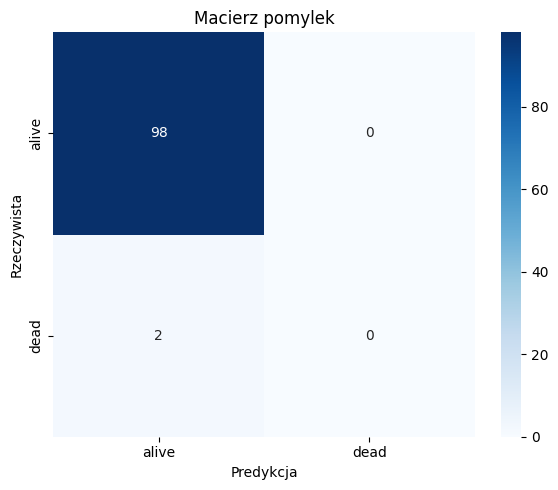

In [52]:
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
print('Accuracy:', acc)
print('Precision (macro):', prec)
print('Recall (macro):', rec)
print('F1 (macro):', f1)
labels_sorted = sorted(y.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels_sorted)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_sorted, yticklabels=labels_sorted)
plt.xlabel('Predykcja')
plt.ylabel('Rzeczywista')
plt.title('Macierz pomylek')
plt.tight_layout()
plt.show()


## 5. Globalna interpretowalnosc ? Permutation Importance

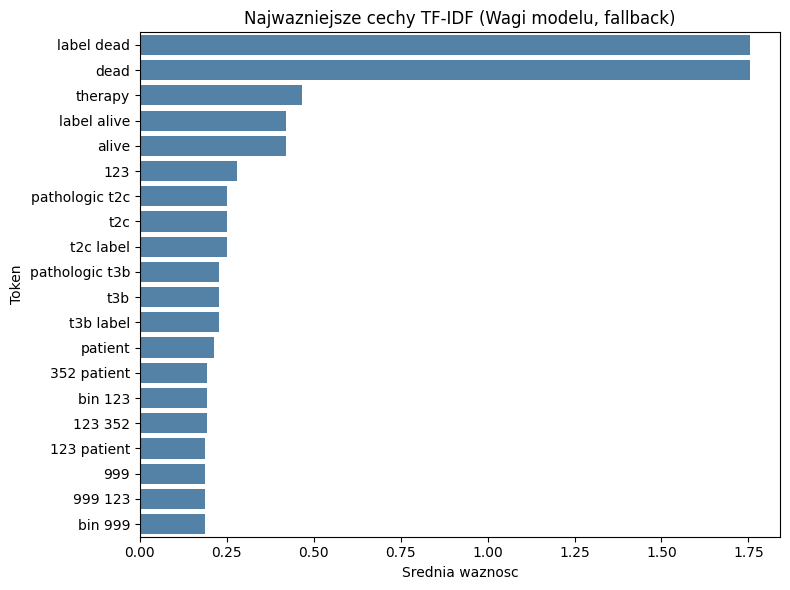

In [53]:
if X_test.shape[0] >= 2:
    X_pi, y_pi = X_test, y_test
elif X_train.shape[0] >= 2:
    X_pi, y_pi = X_train, y_train
else:
    X_pi, y_pi = X, y

X_pi_dense = X_pi.toarray() if hasattr(X_pi, 'toarray') else X_pi
use_perm = (len(np.unique(y_pi)) >= 2) and (X_pi_dense.shape[0] >= 2)

if use_perm:
    perm = permutation_importance(model, X_pi_dense, y_pi, n_repeats=10, random_state=rng, n_jobs=-1, scoring='accuracy')
    importances = perm.importances_mean
else:
    importances = None

feature_names = vectorizer.get_feature_names_out()

if (importances is None) or np.all(np.isnan(importances)) or np.all(np.isclose(importances, 0)):
    coef_abs = np.mean(np.abs(model.coef_), axis=0)
    top_idx = np.argsort(coef_abs)[-20:][::-1]
    top_features = feature_names[top_idx]
    top_importances = coef_abs[top_idx]
    title = 'Najwazniejsze cechy TF-IDF (Wagi modelu, fallback)'
else:
    top_idx = np.argsort(importances)[-20:][::-1]
    top_features = feature_names[top_idx]
    top_importances = importances[top_idx]
    title = 'Najwazniejsze cechy TF-IDF (Permutation Importance)'

plt.figure(figsize=(8, 6))
sns.barplot(x=top_importances, y=top_features, color='steelblue')
plt.title(title)
plt.xlabel('Srednia waznosc')
plt.ylabel('Token')
plt.tight_layout()
plt.show()


## 6. Zaleznosci globalne i lokalne

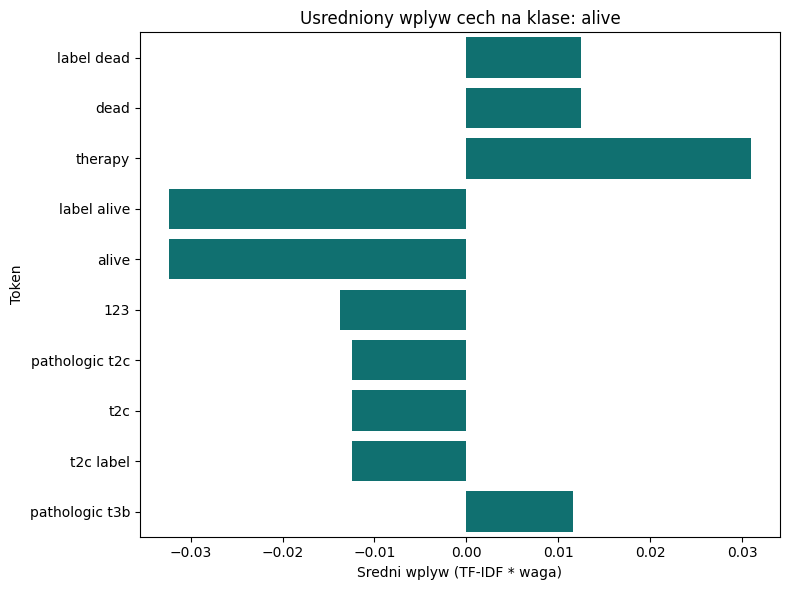

Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.


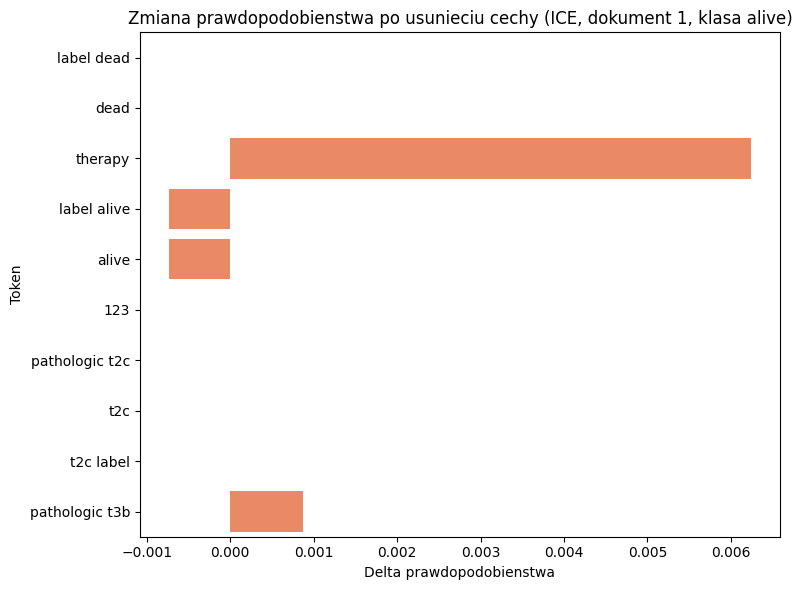

In [54]:
coef_abs = np.mean(np.abs(model.coef_), axis=0)
top_idx = np.argsort(coef_abs)[-10:][::-1]
feature_names = vectorizer.get_feature_names_out()
top_features = feature_names[top_idx]
target_class = y_train.value_counts().idxmax()
class_idx = list(model.classes_).index(target_class)
avg_tfidf = np.asarray(X_test.mean(axis=0)).ravel()
coef_class = model.coef_[class_idx]
global_effect = avg_tfidf[top_idx] * coef_class[top_idx]
plt.figure(figsize=(8, 6))
sns.barplot(x=global_effect, y=top_features, color='teal')
plt.title(f'Usredniony wplyw cech na klase: {target_class}')
plt.xlabel('Sredni wplyw (TF-IDF * waga)')
plt.ylabel('Token')
plt.tight_layout()
plt.show()

x0 = X_test[0].copy().tocsr()
baseline = model.predict_proba(x0)[0][class_idx]
deltas = []
for idx in top_idx:
    x_mod = x0.copy()
    x_mod[0, idx] = 0
    p_mod = model.predict_proba(x_mod)[0][class_idx]
    deltas.append(p_mod - baseline)

plt.figure(figsize=(8, 6))
sns.barplot(x=deltas, y=top_features, color='coral')
plt.title(f'Zmiana prawdopodobienstwa po usunieciu cechy (ICE, dokument 1, klasa {target_class})')
plt.xlabel('Delta prawdopodobienstwa')
plt.ylabel('Token')
plt.tight_layout()
plt.show()


## 7. Wyjasnienia lokalne SHAP

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


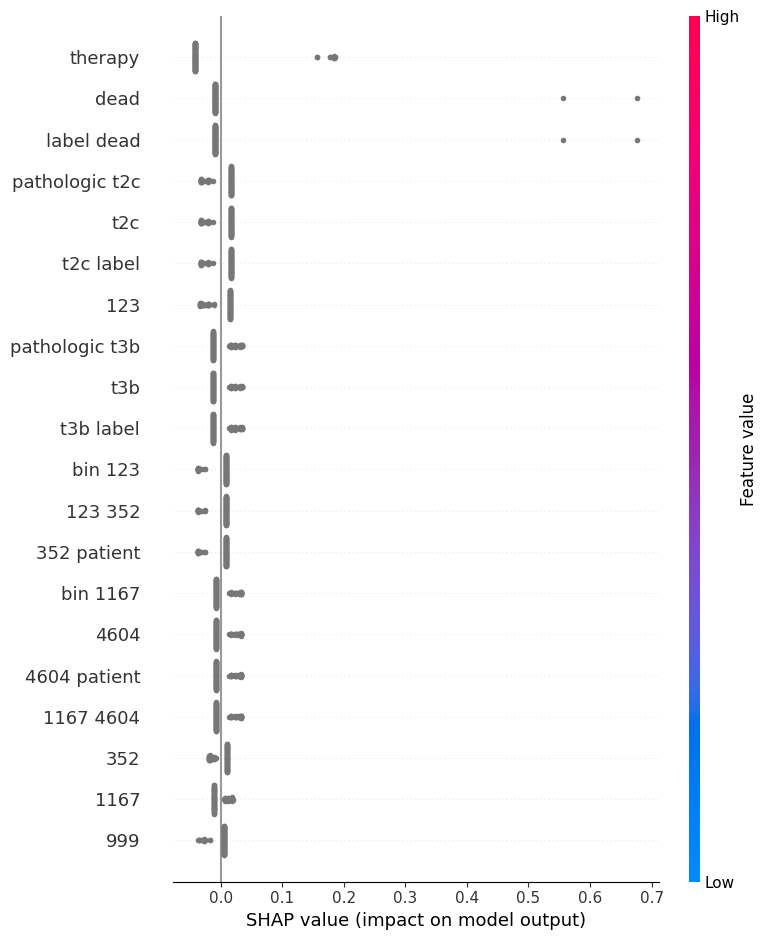

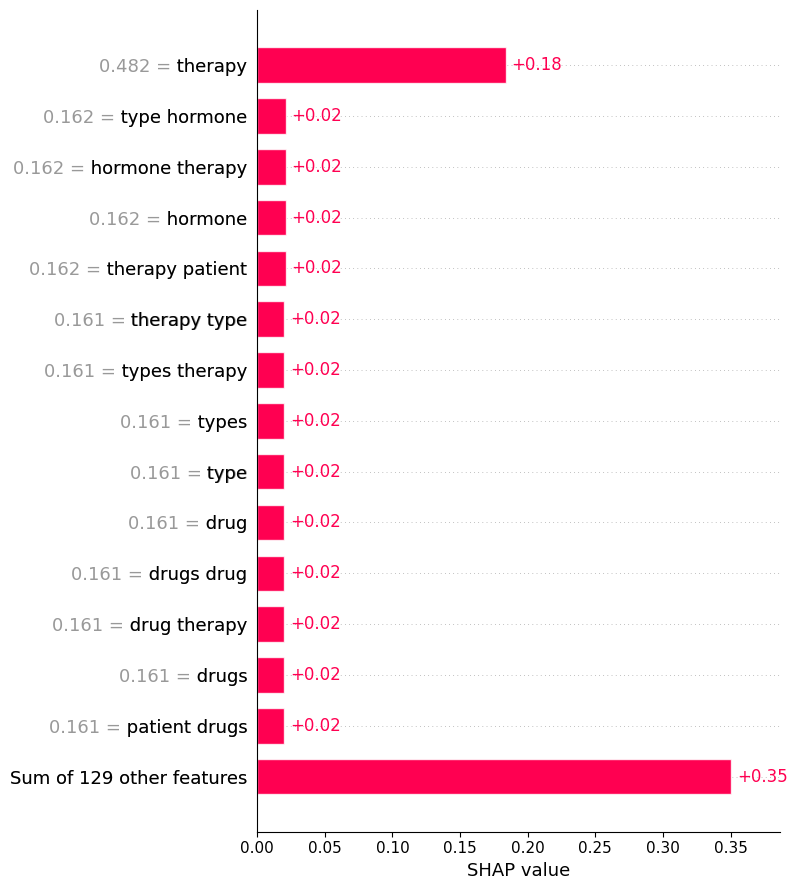

In [55]:
if shap_available:
    shap.initjs()
    explainer = shap.LinearExplainer(model, X_train, feature_perturbation='interventional')
    shap_values = explainer.shap_values(X_test[:200])
    if isinstance(shap_values, list):
        class_idx = list(model.classes_).index(y_train.value_counts().idxmax())
        shap_vals = shap_values[class_idx]
        base_val = explainer.expected_value[class_idx]
    else:
        shap_vals = shap_values
        base_val = explainer.expected_value
    shap.summary_plot(shap_vals, X_test[:200], feature_names=feature_names, show=False)
    plt.tight_layout()
    plt.show()
    i = 0
    x_row = X_test[i].toarray()[0]
    exp = shap.Explanation(values=shap_vals[i], base_values=base_val, data=x_row, feature_names=feature_names)
    shap.plots.bar(exp, max_display=15, show=False)
    plt.tight_layout()
    plt.show()
else:
    print('SHAP nie jest dostepny w tym srodowisku')


## 8. Wyjasnienia lokalne LIME (tekstowe)

[('label_alive', -0.001470234258048305), ('15330', 0.0011810563290956975), ('patient', -0.0009101191063595631), ('352', -0.0007154532949466228), ('20365', 0.0006042697341699357), ('pathologic_categories', -0.00054855334914468), ('692', 0.0005156467307096611), ('tnm_categories', -0.0005015694245072217), ('gender_male', -0.00038591536151449935), ('pathologic_t_t2b', 0.00032963150242939246)]


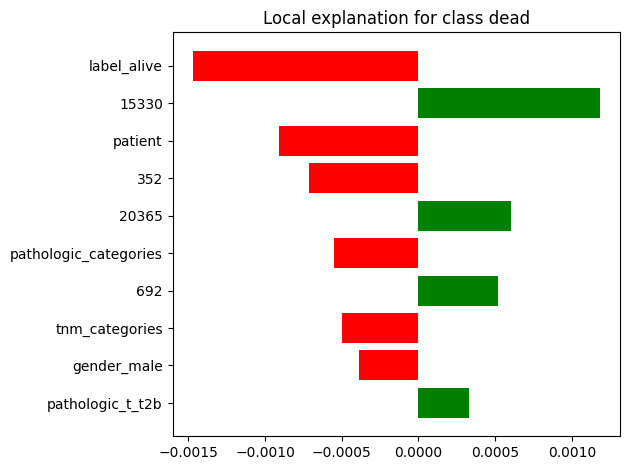

In [56]:
if lime_available:
    explainer = LimeTextExplainer(class_names=model.classes_)
    def predict_proba_lime(texts):
        cleaned = [re.sub(r'[^a-z0-9\s]', ' ', t.lower()) for t in texts]
        cleaned = [re.sub(r'\s+', ' ', t).strip() for t in cleaned]
        X_lime = vectorizer.transform(cleaned)
        return model.predict_proba(X_lime)
    sample_text = df['text'].iloc[0]
    exp = explainer.explain_instance(sample_text, predict_proba_lime, num_features=10)
    print(exp.as_list())
    fig = exp.as_pyplot_figure()
    plt.tight_layout()
    plt.show()
else:
    print('LIME nie jest dostepny w tym srodowisku')
